In [1]:
import warnings
warnings.filterwarnings('ignore')

In [419]:
!pip list

Package               Version
--------------------- -----------
altair                4.2.0
argon2-cffi           21.3.0
argon2-cffi-bindings  21.2.0
asttokens             2.0.8
attrs                 22.1.0
autoviz               0.1.43
backcall              0.2.0
beautifulsoup4        4.11.1
bleach                5.0.1
bokeh                 2.4.3
certifi               2022.6.15
cffi                  1.15.1
charset-normalizer    2.1.1
click                 8.1.3
colorama              0.4.5
colorcet              3.0.0
cycler                0.11.0
debugpy               1.6.3
decorator             5.1.1
defusedxml            0.7.1
emoji                 2.0.0
entrypoints           0.4
executing             0.10.0
fastjsonschema        2.16.1
fonttools             4.37.0
fsspec                2022.7.1
holoviews             1.14.9
htmlmin               0.1.12
hvplot                0.8.0
idna                  3.3
ImageHash             4.2.1
importlib-metadata    4.12.0
ipykernel             6.


[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Libraries

In [3]:
# import sys
# print(sys.path)
# sys.path.insert(0, "C:\\Users\\KonuTech\\gfk_data_analyst\\gfk_ml_ops_data_analyst\\scripts\\python\\")

In [78]:
import os
# import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import math
from pandas_profiling import ProfileReport
# import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scripts.python.get_metrics import *

In [5]:
INPUT_PATH="input"
OUTPUT_PATH="output"
CONFIG_PATH="config"

INPUT_DATA="test_data2"
INPUT_DATA_CONFIG="input_config"
OUTPUT_DATA="output"

INPUT_EXTENSION="csv"
INPUT_CONFIG_EXTENSION="json"
OUTPUT_EXTENSION="csv"

INPUT_FILE=f"{INPUT_DATA}.{INPUT_EXTENSION}"
INPUT_CONFIG_FILE=f"{INPUT_DATA_CONFIG}.{INPUT_CONFIG_EXTENSION}"
OUTPUT_FILE=f"{OUTPUT_DATA}.{OUTPUT_EXTENSION}"

INPUT_ABS_APTH=os.path.abspath(os.path.join(INPUT_PATH, INPUT_FILE))
INPUT_FILE_CONFIG=os.path.abspath(os.path.join(CONFIG_PATH, INPUT_CONFIG_FILE))
OUTPUT_ABS_APTH=os.path.abspath(os.path.join(OUTPUT_PATH, OUTPUT_FILE))

In [6]:
with open(INPUT_FILE_CONFIG, encoding='utf-8') as f:
    CONFIG = json.load(f)

In [7]:
CONFIG

{'INPUTS': {'FILE_NAME': ['test_data2.csv'],
  'SEPARATOR': ',',
  'DECIMAL': None,
  'ENCODING': 'utf-8',
  'FLOAT_PRECISION': 'high',
  'INDEXES': ['period_end_date', 'translated_when'],
  'DATE_COLUMNS': ['period_end_date', 'translated_when'],
  'DTYPE': {'if_data_corrected': 'object',
   'prod_gr_id': 'object',
   'country_id_n': 'object',
   'delivery_type_id': 'object',
   'freq_id': 'object',
   'retailer_id': 'object',
   'brand_id': 'object',
   'predict_automatch': 'float',
   'class_acctual': 'float'},
  'COLUMNS_WITH_NAN_VALUES': [None]},
 'MODEL': [None],
 'OUTPUTS': {'NAME': ['output.csv']}}

# Load data

In [471]:
# LOAD CSV
df = pd.read_csv(
    INPUT_ABS_APTH,
#     index_col=CONFIG['INPUTS']['INDEXES'],
    sep=CONFIG['INPUTS']['SEPARATOR'],
    # quotechar='"',
    # thousands=',',
#     decimal=CONFIG['INPUTS']['DECIMAL'],
    encoding=CONFIG['INPUTS']['ENCODING'],
    infer_datetime_format=True,
    parse_dates=CONFIG['INPUTS']['DATE_COLUMNS'],
    engine="c",
    low_memory=False,
#     float_precision=CONFIG['INPUTS']['DATE_COLUMNS'],
    skipinitialspace=True,
    dtype=CONFIG['INPUTS']['DTYPE']
)

In [472]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19697 entries, 0 to 19696
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   period_end_date    19640 non-null  datetime64[ns, UTC]
 1   translated_when    19697 non-null  datetime64[ns, UTC]
 2   if_data_corrected  19697 non-null  object             
 3   prod_gr_id         19697 non-null  object             
 4   country_id_n       18405 non-null  object             
 5   delivery_type_id   18362 non-null  object             
 6   freq_id            19697 non-null  object             
 7   retailer_id        19697 non-null  object             
 8   brand_id           19697 non-null  object             
 9   predict_automatch  19368 non-null  float64            
 10  class_acctual      19697 non-null  float64            
dtypes: datetime64[ns, UTC](2), float64(2), object(7)
memory usage: 1.7+ MB


In [473]:
df.head(10)

,period_end_date,translated_when,if_data_corrected,prod_gr_id,country_id_n,delivery_type_id,freq_id,retailer_id,brand_id,predict_automatch,class_acctual
0,NaT,2020-10-15 06:58:28+00:00,0,426,121,NaN,2,96,111,1.0,1.0
1,NaT,2020-10-15 06:38:34+00:00,0,426,NaN,NaN,2,92,95,0.0,1.0
2,2020-09-20 00:00:00+00:00,2020-09-23 12:27:51+00:00,0,426,121,42730,2,30,37,1.0,1.0
3,2020-09-20 00:00:00+00:00,2020-09-23 12:26:41+00:00,0,426,121,42730,2,92,203,1.0,1.0
4,2020-09-20 00:00:00+00:00,2020-09-22 09:40:36+00:00,0,426,121,50128,2,9,31,1.0,1.0
5,2020-09-20 00:00:00+00:00,2020-09-25 15:31:09+00:00,0,426,121,19105,2,145,205,1.0,1.0
6,2020-09-20 00:00:00+00:00,2020-09-22 11:18:00+00:00,0,427,108,47990,1,172,237,1.0,1.0
7,2020-09-20 00:00:00+00:00,2020-09-22 11:15:40+00:00,0,427,108,47990,1,133,183,0.0,0.0
8,2020-09-20 00:00:00+00:00,2020-09-22 11:18:32+00:00,0,427,108,47990,2,9,130,1.0,1.0
9,2020-09-20 00:00:00+00:00,2020-09-23 08:00:26+00:00,0,426,121,21378,2,90,76,1.0,1.0


In [474]:
df.describe(
    include='all',
    datetime_is_numeric=True
)

,period_end_date,translated_when,if_data_corrected,prod_gr_id,country_id_n,delivery_type_id,freq_id,retailer_id,brand_id,predict_automatch,class_acctual
count,19640,19697,19697,19697,18405,18362,19697,19697,19697,19368.000000,19697.000000
unique,NaN,NaN,2,3,34,914,2,52,199,NaN,NaN
top,NaN,NaN,0,426,121,31480,2,30,33,NaN,NaN
freq,NaN,NaN,17085,11844,4153,998,11934,1197,587,NaN,NaN
mean,2020-10-14 23:30:22.729124096+00:00,2020-10-22 06:01:21.525206784+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.636307,0.743210
min,2020-08-30 00:00:00+00:00,2020-09-01 03:05:51+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,2020-09-27 00:00:00+00:00,2020-09-29 13:45:29+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,2020-10-18 00:00:00+00:00,2020-10-22 04:30:49+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000
75%,2020-11-08 00:00:00+00:00,2020-11-13 11:57:53+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000
max,2020-12-01 00:00:00+00:00,2021-02-01 14:50:49+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000


# Pandas data profiler

In [12]:
profile = ProfileReport(
    df,
    title="Pandas Profiling Report",
    pool_size=0,
    infer_dtypes=False
)

In [13]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### Offline example of Pandas Profiler widget:

![image info](./docs/images/profiler_example.png)

In [546]:
def get_stacked_bar_chart(data_frame, date_column, column_to_group_by, column_to_count):
    
    plt.figure(figsize=(10, 2))
    
    # legend
    top_bar = mpatches.Patch(color='darkblue', label='No')
    bottom_bar = mpatches.Patch(color='lightblue', label='Yes')
    plt.legend(handles=[top_bar, bottom_bar])
    
#     data_frame.set_index('period_end_date')
    data_frame['month_year'] = data_frame[date_column].dt.to_period('M')
    total = data_frame.groupby([data_frame['month_year'], column_to_group_by])[column_to_count].count().reset_index()
#     print(total)
    
    rate = data_frame[data_frame[column_to_count] == 1].groupby([data_frame['month_year'], column_to_group_by])[column_to_count].sum().reset_index()
#     print(rate)
    
    try:
        rate['rate'] = [i / j * 100 for i, j in zip(rate[column_to_count].fillna(0), total['predict_automatch'].fillna(0))]
    except ZeroDivisionError:
        rate['rate'] = 0
    rate['group'] = rate['month_year'].astype(str) + " " + rate[column_to_group_by].astype(str)
#     print(rate)
    
    total['total_rate'] = [i / j * 100 for i, j in zip(total[column_to_count], total[column_to_count])]
    total['group'] = total['month_year'].astype(str) + " " + total[column_to_group_by].astype(str)
#     print(total)
    
    for group in set(total[column_to_group_by]):
        print(group)
        bar1 = sns.barplot(x='month_year',  y="total_rate", data=total[total[column_to_group_by] == group], color='darkblue')
        bar2 = sns.barplot(x='month_year',  y="rate", data=rate[rate[column_to_group_by] == group], color='lightblue')

        plt.show()

426


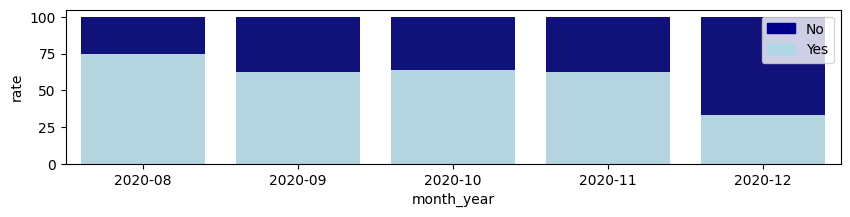

413


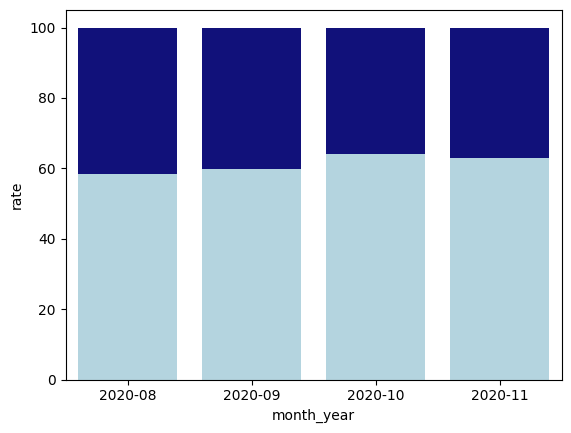

427


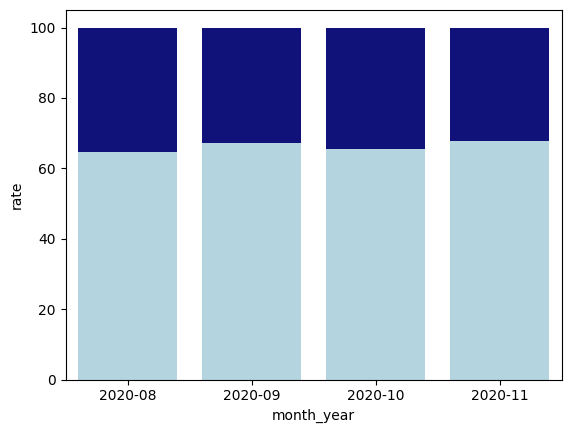

In [552]:
for col in df.columns:
    if col == 'prod_gr_id':

        get_stacked_bar_chart(
                data_frame=df,
                date_column="period_end_date",
                column_to_group_by=col,
                column_to_count='predict_automatch'
            )

In [549]:
for col in df.columns:
    if col == 'country_id_n':

        get_stacked_bar_chart(
                data_frame=df,
                date_column="period_end_date",
                column_to_group_by=col,
                column_to_count='predict_automatch'
            )

ZeroDivisionError: division by zero

In [441]:
# get_stacked_bar_chart(
#     data_frame=df,
#     date_column="period_end_date",
#     column_to_group_by='period_end_date',
#     column_to_count='predict_automatch'
# )

# Post-Processing Bias Metrics for the Trained Model

## Difference in positive proportion in predicted labels (DPPL)

![image info](./docs/images/DPPL.png)

[SOURCE](https://pages.awscloud.com/rs/112-TZM-766/images/Amazon.AI.Fairness.and.Explainability.Whitepaper.pdf)


### CHARACTERISTICS OF METRIC:
> DPPPL > -1 AND DPPPL < 1

> For example, if the model grants loans to 50% of class 2 and to 60% of class 1, then it may be biased against class 2.
We would have to decide whether a 10% difference is material.

## VARIABLE: prod_gr_id

### prod_gr_id total count

In [14]:
total_counts = df.groupby(['prod_gr_id']) \
    .size() \
    .rename('count_total') \
    .reset_index() \
    .sort_values(by='prod_gr_id', ascending=False) \
    .set_index('prod_gr_id')

total_counts

,count_total
prod_gr_id,
427,3367
426,11844
413,4486


### prod_gr_id by predicted classes

In [15]:
grouped_counts = df.groupby(['prod_gr_id', 'predict_automatch']) \
    .size() \
    .rename('count') \
    .reset_index() \
    .sort_values(by='prod_gr_id', ascending=False) \
    .set_index('prod_gr_id')

grouped_counts

,predict_automatch,count
prod_gr_id,,
427,0.0,1116
427,1.0,2235
426,0.0,4278
426,1.0,7298
413,0.0,1650
413,1.0,2791


In [16]:
positive_grouped_counts = grouped_counts.loc[grouped_counts['predict_automatch'] == 1]

positive_grouped_counts

,predict_automatch,count
prod_gr_id,,
427,1.0,2235
426,1.0,7298
413,1.0,2791


In [17]:
merged_counts = pd.merge(positive_grouped_counts, total_counts, left_index=True, right_index=True)

merged_counts

,predict_automatch,count,count_total
prod_gr_id,,,
427,1.0,2235,3367
426,1.0,7298,11844
413,1.0,2791,4486


### (DPPL) for prod_gr_id

In [18]:
ppl_prod_gr_id = get_PPL(
    data_frame=df,
    column_to_group_by='prod_gr_id',
    column_to_count='predict_automatch'
)

ppl_prod_gr_id

prod_gr_id
427    0.663796
426    0.616177
413    0.622158
Name: PPL, dtype: float64

In [19]:
dppl_prod_gr_id = get_DPPL(
    data_frame=df,
    column_to_group_by='prod_gr_id',
    column_to_count='predict_automatch'
)

dppl_prod_gr_id

[-0.047618696554866724,
 -0.04163783945326527,
 -0.0059808571016014556,
 0.0059808571016014556,
 0.04163783945326527,
 0.047618696554866724]

#### Bucketizing dppl_prod_gr_id

In [20]:
print(pd.cut(dppl_prod_gr_id, bins=3).value_counts())

(-0.0477, -0.0159]    2
(-0.0159, 0.0159]     2
(0.0159, 0.0476]      2
dtype: int64


#### CONCLUSIONS:

> Basing solely on **DPPL** we can loosely assume that there is no disparity impact among **prod_gr_id** Classes

## VARIABLE: country_id_n

### country_id_n total count

In [21]:
total_counts = df.groupby(['country_id_n']) \
    .size() \
    .rename('count_total') \
    .reset_index() \
    .sort_values(by='country_id_n', ascending=False) \
    .set_index('country_id_n')

# total_counts

### country_id_n by predicted classes

In [22]:
grouped_counts = df.groupby(['country_id_n', 'predict_automatch']) \
    .size() \
    .rename('count') \
    .reset_index() \
    .sort_values(by='country_id_n', ascending=False) \
    .set_index('country_id_n')

# grouped_counts

In [23]:
positive_grouped_counts = grouped_counts.loc[grouped_counts['predict_automatch'] == 1]

# positive_grouped_counts

In [24]:
merged_counts = pd.merge(positive_grouped_counts, total_counts, left_index=True, right_index=True)

# merged_counts

### (DPPL) for country_id_n

In [25]:
ppl_country_id_n = get_PPL(
    data_frame=df,
    column_to_group_by='country_id_n',
    column_to_count='predict_automatch'
)

ppl_country_id_n

country_id_n
177     0.681818
176     0.664384
160     0.680851
139     0.568493
138     0.634615
136     0.689655
126     0.680945
121     0.649892
116     0.649402
114     0.688312
113     0.665432
110     0.649778
109     0.386667
108     0.690469
107     0.672269
106     0.430536
105     0.670455
104     0.699856
103     0.711691
1011    0.731844
1010    0.680288
1002    0.733333
Name: PPL, dtype: float64

In [26]:
dppl_country_id_n = get_DPPL(
    data_frame=df,
    column_to_group_by='country_id_n',
    column_to_count='predict_automatch'
)

dppl_country_id_n

[-0.3466666666666666,
 -0.3451769087523277,
 -0.32502459326522887,
 -0.3131890331890332,
 -0.30380193390713,
 -0.3029885057471265,
 -0.30279688216414485,
 -0.30164502164502166,
 -0.30130712424980594,
 -0.2951515151515151,
 -0.29427868045297884,
 -0.29418439716312056,
 -0.2936217948717949,
 -0.2856022408963586,
 -0.28378787878787876,
 -0.2811548087627071,
 -0.2787654320987654,
 -0.27771689497716895,
 -0.2693192486865114,
 -0.2632249779276025,
 -0.26311111111111113,
 -0.26273572377158033,
 -0.25993214940460824,
 -0.2591187212446047,
 -0.2577752371424999,
 -0.25128173064899334,
 -0.25040889595045707,
 -0.2503146126605988,
 -0.24975201036927314,
 -0.24794871794871792,
 -0.24173245639383684,
 -0.239918094285357,
 -0.23489564759624365,
 -0.23384711047464718,
 -0.21935519342508075,
 -0.21924132660858936,
 -0.21886593926905856,
 -0.20407893344619615,
 -0.1818264840182649,
 -0.16484018264840172,
 -0.1633504247340628,
 -0.14319810924696397,
 -0.13795669951574313,
 -0.13136254917076828,
 -0.12197

#### Bucketizing dppl_country_id_n

In [27]:
print(pd.cut(dppl_country_id_n, bins=3).value_counts())

(-0.347, -0.116]     47
(-0.116, 0.116]     368
(0.116, 0.347]       47
dtype: int64


#### CONCLUSIONS:

> Although it is likely. Basing solely on **DPPL** we can't assume if there is a disparity impact among **prod_gr_id** Classes yet. 

## Disparate (Adverse) Impact (DI)

![image info](./docs/images/DI.png)

[SOURCE](https://pages.awscloud.com/rs/112-TZM-766/images/Amazon.AI.Fairness.and.Explainability.Whitepaper.pdf)

### CHARACTERISTICS OF METRIC:
> **DI >= 0**

> This measure may be considered fair if it resides in the **<0.8; 1.2>** range.

## (DI) for Variable: prod_gr_id

In [28]:
ppl_prod_gr_id

prod_gr_id
427    0.663796
426    0.616177
413    0.622158
Name: PPL, dtype: float64

In [29]:
di_prod_gr_id = sorted([abs(i / j) for i in ppl_prod_gr_id for j in ppl_prod_gr_id if i != j])

#### Bucketizing di_prod_gr_id

In [30]:
print(pd.cut(di_prod_gr_id, bins=4).value_counts())

(0.928, 0.966]    2
(0.966, 1.003]    1
(1.003, 1.04]     1
(1.04, 1.077]     2
dtype: int64


#### CONCLUSIONS:

> For each possible relation between Classes the metric resides between **<0.8; 1.2>**

> We can loosely assume that there is no disparity impact between Classes of **prod_gr_id** Variable

## (DI) for Variable: country_id_n

In [31]:
ppl_country_id_n

country_id_n
177     0.681818
176     0.664384
160     0.680851
139     0.568493
138     0.634615
136     0.689655
126     0.680945
121     0.649892
116     0.649402
114     0.688312
113     0.665432
110     0.649778
109     0.386667
108     0.690469
107     0.672269
106     0.430536
105     0.670455
104     0.699856
103     0.711691
1011    0.731844
1010    0.680288
1002    0.733333
Name: PPL, dtype: float64

In [32]:
di_country_id_n = sorted([abs(i / j) for i in ppl_country_id_n for j in ppl_country_id_n if i != j])

#### Bucketizing di_country_id_n

In [33]:
print(pd.cut(di_country_id_n, bins=4).value_counts())

(0.526, 0.87]      57
(0.87, 1.212]     359
(1.212, 1.554]     14
(1.554, 1.897]     32
dtype: int64


> Dividing Ratios by Ratios, so values close to 1 are good

In [34]:
pd.Series(di_country_id_n).describe()

count    462.000000
mean       1.025311
std        0.238095
min        0.527273
25%        0.943997
50%        1.000000
75%        1.059325
max        1.896552
dtype: float64

#### CONCLUSIONS:

> There is more than 100 Classes of Variable **country_id_n** out of **<0.8; 1.2>** bounds.

> At this moment we can loosely assume that there are some examples of Disparity Impact in case of **country_id_n** Variable.

## Difference in Conditional Outcome (DCO)
> Type 1: **Difference in Conditional Acceptance (DCA)**

> Type 2: **Difference in Conditional Rejection (DCR)**

> When both **DCA** and **DCR** are very close to **0**, we can conclude that the proportion of qualified (as suggested by observed labels) applicants accepted by the model and the proportion of unqualified applicants rejected are nearly equal across both classes.

### Difference in Conditional Acceptance (DCA)

![image info](./docs/images/DCA.jpg)

[SOURCE](https://pages.awscloud.com/rs/112-TZM-766/images/Amazon.AI.Fairness.and.Explainability.Whitepaper.pdf)

#### CHARACTERISTICS OF METRIC:
> Unbounded

> Zero denominator is possible. In such case the allocations to each Class are too small and a warning should be issued.

## (DCA) for Variable: prod_gr_id

In [35]:
ca_prod_gr_id = get_CA(
    data_frame=df,
    column_to_group_by='prod_gr_id',
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch'
)

ca_prod_gr_id

prod_gr_id
427    1.114989
426    1.203069
413    1.206378
Name: CA, dtype: float64

In [36]:
dca_prod_gr_id = get_DCA(
    data_frame=df,
    column_to_group_by='prod_gr_id',
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch'
)

dca_prod_gr_id

[-0.09138882810439752,
 -0.08808051974645381,
 -0.0033083083579437123,
 0.0033083083579437123,
 0.08808051974645381,
 0.09138882810439752]

#### Bucketizing dca_prod_gr_id

In [37]:
print(pd.cut(dca_prod_gr_id, bins=3).value_counts())

(-0.0916, -0.0305]    2
(-0.0305, 0.0305]     2
(0.0305, 0.0914]      2
dtype: int64


#### CONCLUSIONS:

> TODO: Diffrances are really small

## (DCA) for Variable: country_id_n

In [38]:
ca_country_id_n = get_CA(
    data_frame=df,
    column_to_group_by='country_id_n',
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch'
)

ca_country_id_n

country_id_n
177     1.040000
176     1.120766
160     1.031250
139     1.317269
138     1.212121
136     1.050000
126     1.090022
121     1.133012
116     1.147239
114     1.085954
113     1.123377
110     1.136799
109     2.000000
108     1.072022
107     1.079167
106     1.686901
105     1.105932
104     1.045361
103     1.063796
1011    1.091603
1010    1.116608
1002    1.090909
Name: CA, dtype: float64

In [72]:
df[df['country_id_n']=='109'].describe()

,predict_automatch,class_acctual
count,373.000000,375.000000
mean,0.388740,0.773333
std,0.488119,0.419235
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


> from the CA and mean we can assume that the Model underperforms when 'country_id_n'=='109'

In [39]:
dca_country_id_n = get_DCA(
    data_frame=df,
    column_to_group_by='country_id_n',
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch'
)

dca_country_id_n

[-0.96875,
 -0.96,
 -0.9546391752577319,
 -0.95,
 -0.9362041467304625,
 -0.9279778393351801,
 -0.9208333333333334,
 -0.9140461215932913,
 -0.9099783080260304,
 -0.9090909090909092,
 -0.9083969465648856,
 -0.8940677966101696,
 -0.88339222614841,
 -0.8792341678939617,
 -0.8766233766233766,
 -0.8669877732493516,
 -0.8632010943912449,
 -0.852760736196319,
 -0.7878787878787878,
 -0.6827309236947792,
 -0.6556509584664536,
 -0.6469009584664536,
 -0.6415401337241855,
 -0.6369009584664536,
 -0.6231051051969161,
 -0.6148787978016337,
 -0.607734291799787,
 -0.600947080059745,
 -0.596879266492484,
 -0.5959918675573628,
 -0.5952979050313392,
 -0.5809687550766232,
 -0.5702931846148636,
 -0.5661351263604153,
 -0.5635243350898302,
 -0.5538887317158052,
 -0.5501020528576985,
 -0.5396616946627726,
 -0.47477974634524145,
 -0.36963188216123277,
 -0.3130990415335464,
 -0.28601907630522083,
 -0.2772690763052208,
 -0.27190825156295273,
 -0.2672690763052208,
 -0.2534732230356833,
 -0.2452469156404009,
 -0.238

#### Bucketizing dca_country_id_n

In [40]:
print(pd.cut(dca_country_id_n, bins=3).value_counts())

(-0.971, -0.323]     40
(-0.323, 0.323]     382
(0.323, 0.969]       40
dtype: int64


#### CONCLUSIONS:

> TODO:

### Difference in Conditional Rejection (DCR)

![image info](./docs/images/DCR.jpg)

[SOURCE](https://pages.awscloud.com/rs/112-TZM-766/images/Amazon.AI.Fairness.and.Explainability.Whitepaper.pdf)

#### CHARACTERISTICS OF METRIC:
> Unbounded

> Zero denominator is possible. In such case the allocations to each Class are too small and a warning should be issued.

## (DCR) for Variable: prod_gr_id

In [41]:
cr_prod_gr_id = get_CR(
    data_frame=df,
    column_to_group_by='prod_gr_id',
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch'
)

cr_prod_gr_id

prod_gr_id
427    0.784050
426    0.716223
413    0.678182
Name: CR, dtype: float64

In [42]:
dcr_prod_gr_id = get_DCR(
    data_frame=df,
    column_to_group_by='prod_gr_id',
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch'
)

dcr_prod_gr_id

[-0.10586836102965136,
 -0.06782764531712637,
 -0.038040715712524986,
 0.038040715712524986,
 0.06782764531712637,
 0.10586836102965136]

#### Bucketizing dcr_prod_gr_id

In [43]:
print(pd.cut(dcr_prod_gr_id, bins=3).value_counts())

(-0.106, -0.0353]    3
(-0.0353, 0.0353]    0
(0.0353, 0.106]      3
dtype: int64


#### CONCLUSIONS:

> TODO:

## (DCR) for Variable: country_id_n

In [44]:
cr_country_id_n = get_CR(
    data_frame=df,
    column_to_group_by='country_id_n',
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch'
)

cr_country_id_n

country_id_n
177     0.914286
176     0.765396
160     0.933333
139     0.582011
138     0.648649
136     0.888889
126     0.817330
121     0.784384
116     0.920863
114     0.817757
113     0.768797
110     0.942308
109     0.372807
108     0.849844
107     0.844828
106     0.481840
105     0.798246
104     0.916256
103     0.856000
1011    0.765957
1010    0.763359
1002    0.750000
Name: CR, dtype: float64

In [45]:
dcr_country_id_n = get_DCR(
    data_frame=df,
    column_to_group_by='country_id_n',
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch'
)

dcr_country_id_n

[-0.5695006747638327,
 -0.5605263157894738,
 -0.5480562918086584,
 -0.5434491400916084,
 -0.5414786967418546,
 -0.5160818713450293,
 -0.48319298245614034,
 -0.47703656952600476,
 -0.47202056866303693,
 -0.46046749860309183,
 -0.4514931396287329,
 -0.4449499918019348,
 -0.4445231932289741,
 -0.4390231156479176,
 -0.4344159639308675,
 -0.4324455205811138,
 -0.4254385964912281,
 -0.4115769366108682,
 -0.4070486951842884,
 -0.3959899749373434,
 -0.393150429264651,
 -0.39258887688429284,
 -0.3905517610820946,
 -0.37719298245614036,
 -0.3741598062953995,
 -0.36800339336526394,
 -0.3629873925022961,
 -0.3602971102971103,
 -0.35132275132275137,
 -0.33885272734193606,
 -0.33591681564119397,
 -0.3354900170682333,
 -0.334245575624886,
 -0.3322751322751323,
 -0.3164054203304873,
 -0.30687830687830686,
 -0.3025437604501274,
 -0.2936590436590436,
 -0.2869567987766026,
 -0.28468468468468466,
 -0.2841172531039102,
 -0.283555700723552,
 -0.2815185849213538,
 -0.27584163110478904,
 -0.273989417989418,
 

#### Bucketizing dcr_country_id_n

In [46]:
print(pd.cut(dcr_country_id_n, bins=3).value_counts())

(-0.571, -0.19]     61
(-0.19, 0.19]      340
(0.19, 0.57]        61
dtype: int64


#### CONCLUSIONS:

> TODO:

In [47]:
cm_by_class_prod_gr_id = get_class_cm(
    data_frame=df,
    acctuals='class_acctual',
    predictions='predict_automatch',
    column_to_group_by='prod_gr_id'
)

cm_by_class_prod_gr_id

,Class,TN,FN,FP,TP
0,426,75,193,2989,8587
1,427,4,12,871,2480
2,413,11,34,1108,3333


In [48]:
rd_prod_gr_id = get_RD(
    data_frame=df,
    acctuals='class_acctual',
    predictions='predict_automatch',
    column_to_group_by='prod_gr_id'
)

rd_prod_gr_id

[-0.01716636745558453,
 -0.01188376666736568,
 -0.00528260078821885,
 0.00528260078821885,
 0.01188376666736568,
 0.01716636745558453]

#### Bucketizing rd_prod_gr_id

In [49]:
print(pd.cut(rd_prod_gr_id, bins=3).value_counts())

(-0.0172, -0.00572]    2
(-0.00572, 0.00572]    2
(0.00572, 0.0172]      2
dtype: int64


#### CONCLUSIONS:

> TODO:

## (RD) for Variable: country_id_n

In [50]:
cm_by_class_prod_gr_id = get_class_cm(
    data_frame=df,
    acctuals='class_acctual',
    predictions='predict_automatch',
    column_to_group_by='country_id_n'
)

cm_by_class_prod_gr_id

,Class,TN,FN,FP,TP
0,121,17,41,1078,3017
1,108,3,9,812,2313
2,176,0,2,261,759
3,110,25,57,269,774
4,139,0,0,110,328
5,114,1,1,174,517
6,105,0,2,91,259
7,116,11,26,117,348
8,106,0,1,199,527
9,104,3,2,183,505


In [51]:
recall_by_class = get_RD(
    data_frame=df,
    acctuals='class_acctual',
    predictions='predict_automatch',
    column_to_group_by='country_id_n'
)

recall_by_class

[-1.0,
 -0.9981060606060606,
 -0.9980694980694981,
 -0.9973718791064389,
 -0.9970014992503748,
 -0.9961389961389961,
 -0.9961240310077519,
 -0.9960552268244576,
 -0.9960199004975124,
 -0.9936708860759493,
 -0.993103448275862,
 -0.993006993006993,
 -0.9925681255161024,
 -0.9923371647509579,
 -0.986592544146501,
 -0.9314079422382672,
 -0.93048128342246,
 -0.06951871657754005,
 -0.06859205776173283,
 -0.0676247771836006,
 -0.06758821464703813,
 -0.06689059568397893,
 -0.06669811836779338,
 -0.0666615558312309,
 -0.0665202158279149,
 -0.0659639368681717,
 -0.0656577127165362,
 -0.06564274758529198,
 -0.06559355701210767,
 -0.06557394340199763,
 -0.06553861707505249,
 -0.06473105390072897,
 -0.06471608876948476,
 -0.0646472845861904,
 -0.06461195825924526,
 -0.06318960265348939,
 -0.0626221648534021,
 -0.06252570958453307,
 -0.06226294383768216,
 -0.06208684209364246,
 -0.06185588132849795,
 -0.06169550603759488,
 -0.06159905076872585,
 -0.061160183277835234,
 -0.06092922251269073,
 -0.0561

#### Bucketizing recall_by_class

In [52]:
print(pd.cut(recall_by_class, bins=3).value_counts())

(-1.002, -0.333]     17
(-0.333, 0.333]     270
(0.333, 1.0]         17
dtype: int64


#### CONCLUSIONS:

> TODO:

## Difference in label rates (DLR)

![image info](./docs/images/DAR.png)

[SOURCE](https://pages.awscloud.com/rs/112-TZM-766/images/Amazon.AI.Fairness.and.Explainability.Whitepaper.pdf)

#### CHARACTERISTICS OF METRIC:
> DAR > -1 AND DAR < 1

> DRR > -1 AND DRR < 1

> DAR is the same as precision difference between the first and second classes.

## (DAR) for Variable: prod_gr_id

In [53]:
ar_by_class_prod_gr_id = get_AR(
    data_frame=df,
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch',
    column_to_group_by='prod_gr_id'
)

ar_by_class_prod_gr_id

,class_acctual,count_grouped_acctuals,predict_automatch,count_gruped_predictions,Class,TN,FN,FP,TP
0,1.0,2492,1.0,2235,427,4,12,871,2480
1,1.0,8780,1.0,7298,426,75,193,2989,8587
2,1.0,3367,1.0,2791,413,11,34,1108,3333


In [54]:
dar_by_class_prod_gr_id = get_DAR(
    data_frame=df,
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch',
    column_to_group_by='prod_gr_id'
)

dar_by_class_prod_gr_id

[-0.0845759420059844,
 -0.06700404572856522,
 -0.017571896277419174,
 0.017571896277419174,
 0.06700404572856522,
 0.0845759420059844]

#### Bucketizing dar_by_class_prod_gr_id

In [55]:
print(pd.cut(dar_by_class_prod_gr_id, bins=3).value_counts())

(-0.0847, -0.0282]    2
(-0.0282, 0.0282]     2
(0.0282, 0.0846]      2
dtype: int64


## (DRR) for Variable: prod_gr_id

In [56]:
rr_by_class_prod_gr_id = get_RR(
    data_frame=df,
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch',
    column_to_group_by='prod_gr_id'
)

rr_by_class_prod_gr_id

,class_acctual,count_grouped_acctuals,predict_automatch,count_gruped_predictions,Class,TN,FN,FP,TP
0,0.0,875,0.0,1116,427,4,12,871,2480
1,0.0,3064,0.0,4278,426,75,193,2989,8587
2,0.0,1119,0.0,1650,413,11,34,1108,3333


In [57]:
drr_by_class_prod_gr_id = get_DRR(
    data_frame=df,
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch',
    column_to_group_by='prod_gr_id'
)

drr_by_class_prod_gr_id

[-0.008487078988880532,
 -0.006335548462107435,
 -0.0021515305267730965,
 0.0021515305267730965,
 0.006335548462107435,
 0.008487078988880532]

#### Bucketizing dar_by_class_prod_gr_id

In [58]:
print(pd.cut(drr_by_class_prod_gr_id, bins=3).value_counts())

(-0.0085, -0.00283]    2
(-0.00283, 0.00283]    2
(0.00283, 0.00849]     2
dtype: int64


#### CONCLUSIONS:

> TODO:

## (DAR) for Variable: country_id_n

In [59]:
ar_by_class_country_id_n = get_AR(
    data_frame=df,
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch',
    column_to_group_by='country_id_n'
)

ar_by_class_country_id_n

,class_acctual,count_grouped_acctuals,predict_automatch,count_gruped_predictions,Class,TN,FN,FP,TP
0,1.0,78,1.0,75,177,0,0,32,78
1,1.0,761,1.0,679,176,0,2,261,759
2,1.0,33,1.0,32,160,0,0,14,33
3,1.0,328,1.0,249,139,0,0,110,328
4,1.0,80,1.0,66,138,1,0,23,80
5,1.0,21,1.0,20,136,0,0,8,21
6,1.0,1005,1.0,922,126,1,4,348,1001
7,1.0,3058,1.0,2699,121,17,41,1078,3017
8,1.0,374,1.0,326,116,11,26,117,348
9,1.0,518,1.0,477,114,1,1,174,517


In [60]:
dar_by_class_country_id_n = get_DAR(
    data_frame=df,
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch',
    column_to_group_by='country_id_n'
)

dar_by_class_country_id_n

[-0.9549568965517241,
 -0.9462068965517241,
 -0.9449697831496622,
 -0.9362068965517241,
 -0.9273833671399594,
 -0.9256008359456636,
 -0.9187222339750369,
 -0.9183398605406439,
 -0.9112068965517242,
 -0.9023494542037158,
 -0.9022374309028691,
 -0.9005235993716807,
 -0.8952978056426333,
 -0.8887492694330801,
 -0.8766662605093214,
 -0.8711790672381805,
 -0.8683865725458331,
 -0.8683854812127096,
 -0.774085684430512,
 -0.6689378202465033,
 -0.6524560702875399,
 -0.6437060702875399,
 -0.642468956885478,
 -0.6337060702875399,
 -0.6248825408757752,
 -0.6231000096814794,
 -0.6162214077108528,
 -0.6158390342764597,
 -0.60870607028754,
 -0.5998486279395316,
 -0.599736604638685,
 -0.5980227731074965,
 -0.5927969793784491,
 -0.5862484431688959,
 -0.5741654342451372,
 -0.5686782409739963,
 -0.5658857462816489,
 -0.5658846549485255,
 -0.4715848581663278,
 -0.3664369939823191,
 -0.3025008262641842,
 -0.28601907630522083,
 -0.2772690763052208,
 -0.2760319629031589,
 -0.2672690763052208,
 -0.2584455468

#### Bucketizing dar_by_class_prod_gr_id

In [61]:
print(pd.cut(dar_by_class_country_id_n, bins=3).value_counts())

(-0.957, -0.318]     40
(-0.318, 0.318]     382
(0.318, 0.955]       40
dtype: int64


## (DRR) for Variable: country_id_n

In [62]:
rr_by_class_country_id_n = get_RR(
    data_frame=df,
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch',
    column_to_group_by='country_id_n'
)

rr_by_class_country_id_n

,class_acctual,count_grouped_acctuals,predict_automatch,count_gruped_predictions,Class,TN,FN,FP,TP
0,0.0,32,0.0,35,177,0,0,32,78
1,0.0,261,0.0,341,176,0,2,261,759
2,0.0,14,0.0,15,160,0,0,14,33
3,0.0,110,0.0,189,139,0,0,110,328
4,0.0,24,0.0,37,138,1,0,23,80
5,0.0,8,0.0,9,136,0,0,8,21
6,0.0,349,0.0,427,126,1,4,348,1001
7,0.0,1095,0.0,1396,121,17,41,1078,3017
8,0.0,128,0.0,139,116,11,26,117,348
9,0.0,175,0.0,214,114,1,1,174,517


In [63]:
drr_by_class_country_id_n = get_DRR(
    data_frame=df,
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch',
    column_to_group_by='country_id_n'
)

drr_by_class_country_id_n

[-0.03419972640218878,
 -0.03374233128834356,
 -0.03327208261740214,
 -0.03311512770370722,
 -0.032814687503556914,
 -0.032814684850942244,
 -0.032657732589861994,
 -0.03235728973709702,
 -0.03210329034348857,
 -0.031645895229643346,
 -0.031009933738711908,
 -0.030552538624866683,
 -0.028014159391879505,
 -0.027901097280291783,
 -0.02755676427803428,
 -0.02744370216644656,
 -0.01904821125067363,
 -0.018590816136828406,
 -0.015151515151515152,
 -0.01422387136672851,
 -0.01406691645303359,
 -0.013766473600268614,
 -0.013055079092814942,
 -0.011961722488038277,
 -0.008965948141205875,
 -0.008852886029618152,
 -0.006298629121896999,
 -0.006185567010309278,
 -0.005370985337110357,
 -0.0052579232255226364,
 -0.005214030423415437,
 -0.005100968311827716,
 -0.004913587570650461,
 -0.004800525459062741,
 -0.004202193063196789,
 -0.004089130951609068,
 -0.003189792663476874,
 -0.0031088364584201246,
 -0.002995774346832404,
 -0.002262148878690232,
 -0.002105193964995312,
 -0.0020964360587002098,


#### Bucketizing dar_by_class_prod_gr_id

In [64]:
print(pd.cut(drr_by_class_country_id_n, bins=3).value_counts())

(-0.0343, -0.0114]    24
(-0.0114, 0.0114]     62
(0.0114, 0.0342]      24
dtype: int64


#### CONCLUSIONS:

> TODO:

## Accuracy DIfference (AD)

![image info](./docs/images/AD.jpg)

[SOURCE](https://pages.awscloud.com/rs/112-TZM-766/images/Amazon.AI.Fairness.and.Explainability.Whitepaper.pdf)

#### CHARACTERISTICS OF METRIC:
> Unbounded metric

> Care needed when FN = 0

## (AD) for Variable: prod_gr_id

In [65]:
a_by_class_prod_gr_id = get_A(
    data_frame=df,
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch',
    column_to_group_by='prod_gr_id'
)

rr_by_class_prod_gr_id

,class_acctual,count_grouped_acctuals,predict_automatch,count_gruped_predictions,Class,TN,FN,FP,TP
0,0.0,875,0.0,1116,427,4,12,871,2480
1,0.0,3064,0.0,4278,426,75,193,2989,8587
2,0.0,1119,0.0,1650,413,11,34,1108,3333


In [66]:
ad_by_class_country_id_n = get_AD(
    data_frame=df,
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch',
    column_to_group_by='prod_gr_id'
)

ad_by_class_country_id_n

[-0.014089464118395734,
 -0.007681489625314897,
 -0.006407974493080837,
 0.006407974493080837,
 0.007681489625314897,
 0.014089464118395734]

#### Bucketizing dar_by_class_prod_gr_id

In [67]:
print(pd.cut(ad_by_class_country_id_n, bins=3).value_counts())

(-0.0141, -0.0047]    3
(-0.0047, 0.0047]     0
(0.0047, 0.0141]      3
dtype: int64


#### CONCLUSIONS:

> TODO:

## (AD) for Variable: country_id_n

In [68]:
a_by_class_country_id_n = get_A(
    data_frame=df,
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch',
    column_to_group_by='country_id_n'
)

rr_by_class_country_id_n

,class_acctual,count_grouped_acctuals,predict_automatch,count_gruped_predictions,Class,TN,FN,FP,TP
0,0.0,32,0.0,35,177,0,0,32,78
1,0.0,261,0.0,341,176,0,2,261,759
2,0.0,14,0.0,15,160,0,0,14,33
3,0.0,110,0.0,189,139,0,0,110,328
4,0.0,24,0.0,37,138,1,0,23,80
5,0.0,8,0.0,9,136,0,0,8,21
6,0.0,349,0.0,427,126,1,4,348,1001
7,0.0,1095,0.0,1396,121,17,41,1078,3017
8,0.0,128,0.0,139,116,11,26,117,348
9,0.0,175,0.0,214,114,1,1,174,517


In [69]:
ad_by_class_country_id_n = get_AD(
    data_frame=df,
    column_to_count_acctuals='class_acctual',
    column_to_count_predictions='predict_automatch',
    column_to_group_by='country_id_n'
)

ad_by_class_country_id_n

[-0.09787234042553195,
 -0.09116842981100681,
 -0.09090909090909094,
 -0.08977777777777785,
 -0.08486055776892432,
 -0.0842051802945658,
 -0.08307386716325271,
 -0.07815664715439918,
 -0.07731092436974796,
 -0.07671849427168576,
 -0.07586206896551728,
 -0.07510316368638248,
 -0.07060701375522282,
 -0.06975524475524475,
 -0.06944377558391523,
 -0.06915815835099215,
 -0.06862393162393166,
 -0.06839925307185735,
 -0.06695526695526699,
 -0.06587234042553192,
 -0.06420454545454546,
 -0.06370671161507813,
 -0.0627398649693901,
 -0.06171501434491555,
 -0.06025135634074186,
 -0.0599704579025111,
 -0.05890909090909091,
 -0.05777777777777782,
 -0.057500634840020326,
 -0.05740740740740746,
 -0.05733855185909986,
 -0.05615707821590177,
 -0.05501110373039042,
 -0.054966551549254894,
 -0.05470822281167109,
 -0.05394931753253629,
 -0.053266547287985966,
 -0.05286055776892429,
 -0.05268003273322419,
 -0.05252525252525253,
 -0.05114155251141561,
 -0.05070349679288233,
 -0.05063464124457473,
 -0.0482899

#### Bucketizing dar_by_class_prod_gr_id

In [70]:
print(pd.cut(ad_by_class_country_id_n, bins=3).value_counts())

(-0.0981, -0.0326]     83
(-0.0326, 0.0326]     296
(0.0326, 0.0979]       83
dtype: int64


#### CONCLUSIONS:

> TODO: